# ACS2 in Maze Experiments
The following notebooks provides reproducible playground for experimenting how ACS2 agent behaves inside Maze environments.

TODO:
- check if classifiers with $q < 0.1$ are deleted,

#### Resources
- Nice [presentation](http://www.psychologie.uni-wuerzburg.de/stolzmann/ACS-tutorial/ACS-tutorial.pdf),

### History of ACS
First ALCS ([ACS](http://www.psychologie.uni-wuerzburg.de/stolzmann/gp-98.ps.gz)) was developed by Stolzmanm in 1997 (with puts an additional anticipatory part in each classifier). Another ALCS with an explicit anticipatory part [YACS](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.26.1149), has been published in Gerard and Siguad (2001). Tomlison and Bull (2000) published a cooperate learning classifier system ([CXCS](http://dl.acm.org/citation.cfm?id=689033)) in which cooperations between rules allow antitipatory proceses.


ACS2 (derived from Stolzmann's work) is intendet to create a solution that is *complete*, *accurate* and *maximally general*. Major differences between ACS and ACS2:
- ACS2 evolves explicit rules for situation-action tuples in which no changes occurs (a *pass-through-symbol* in E part **requires** a change in value),
- ACS2's ALP (specialization pressure) and GA (generalization pressure) processes are improved

### Knowledge representation
Knowledge in an ACS2 is represented by a population of classifiers. Each classifier represents a *condition-action-effect* that anticipates the model *state* resulting from the execution of the *action* given the specified *conditions*.

> A classifier in ACS2 always specifes a complete resulting state.

It consists of the following main components:
- *condition part (C)* - specifies the set of situations in which a classifier is applicable,
- *action part (A)* - proposes an available action,
- *effect part (E)* - anticipates the effects of the proposed action in the specific conditions,
- *quality (q)* - measures the accuracy of the anticipated results, $q \in [0,1]$,
- *reward prediction (r)* - estimates the reward encountered after the execution of action A in condition C, $r \in \!R$
- *intermediate reward prediction (ir)* - estimates the *direct* reinforcement encountered after execution of action A in condition C, $ir \in \!R$

The *condition* and *effect* part consist of the values perceived from the environment and `#` symbols (i.e. $C,E \in \{ l_1, l_2, \dots, l_m, \# \}^L$. 

> A `#`-symbol in the:
- condition part is called *"don't care"* and denotes that the classifier matches any value in this attribute,
- effect part is called *"pass-through"* specifies that the classifier anticipates that the value of this attribute will not change after the execution of the specified action

> **Non pass-through symbols in E anticipate the change of the particular attribute to the specified value** (in contrast to ACS in which a non pass-through symbol did not require a change in value).

Additionally each classifier compromises:
- *Mark (M)* - records the values of each attribute of all situations in which the classifer did not anticipate correctly sometimes,
- *GA timestamp ($t_{ga}$)* - timestamp when GA was last applied,
- *ALP timestamp ($t_{alp}$)* - timestamp when ALP was last applied,
- *application average (aav)* - estimates the frequency a classifier is updated (i.e. part of an action set),
- *experience counter (exp)* - counts the number of applications,
- *numerosity (num)* - denotes the number of micro-classifers this macroclassifier represents (one classifier may represent many identical micro-classifier)

### Agent interaction
ACS2 interacts *autonomously* with an environment.
<img src="temp/agent_environment_interaction.png" alt="agent_env_interaction" style="width: 400px;"/>

In a *behavioral act* at a certain time $t$, the agent perceives a situation $\sigma(t) = \{ l_1, l_2, \dots, l_m \}^L$, where: 

- $m$ denotes the number of possible values of each environmental attribute (or feature), 
- $l_1, l_2, \dots, l_n$ denote the different possible values for each attribute,
- $L$ denotes the string length.

> Note that each attribute can only take **discrete** values.

The system can act upon the environment with an action $\alpha(t) = \{ \alpha_1, \alpha_2, \dots, \alpha_n \}$, where:

- $n$ specifies the number of different possible actions in in the environment,
- $\alpha_1, \alpha_2, \dots, \alpha_n$ denote the different possible actions

After the execution of an action, the environment provides a scalar reinforcement value $\rho(t) \in \mathbb{R}$

### Environmental Model
By interacting with the environemnt the ACS2 learns about it's structure. Usually the agent starts without any prior knowledge. Initially new classifiers are mainly generated by a *covering* mechanizm in ALP. Later the ALP generates specialized clasifiers while the GG tries to introduce some genetic generalization.

Figure below presents the interaction with greater details.
1. After the **perception of the current situation** $\sigma(t)$, ACS2 forms a **match set** `[M]` comprising all classifiers in the population `[P]` whose conditions are satisfied in $\sigma(t)$,
2. ACS2 **chooses an action** $\alpha(t)$ according to some strategy (see below),
3. With respect to the chosen action, an **action set** `[A]` is generated that consist of all classifiers in `[M]` that specify the chosen action $\alpha(t)$,
4. After the execution of $\alpha(t)$ **classifier parameters are updated** by ALP and RL. New classifiers might be added or deleted due to the ALP and GG (see below).


<img src="temp/ACS2.png" alt="Environmental model" style="width: 600px;"/>

##### Action selection Strategies
Possible strategies used for choosing which action to execute next:

- $\epsilon$-greedy (Sutton and Barto, 1998, often used in reinforcement learning),
- ...

#### Anticipatory Learning Process (ALP)
The ALP was originally derived from the cognitive theory of anticipatory behavioral control (Hoffman, 1993). The process results in the evaluation and specialization of the anticipatory model in ACS2.

> ALP first update classifier parameters. Next an offspring is generated and inaccuate classifiers are removed.

##### Parameter updates
The following parameters are updated in the **following order** - quality ($q$), mark ($M$), application average ($aav$), ALP timestamp ($t_{alp}$) and the experience counter ($exp$).

###### Quality
The quality $q$ is updated according to the classifiers anticipation. If the classifier predicted correctly, the quality is increased using the following formula:
$$q \leftarrow q + \beta (1- q)$$

Otherwise it is decreased:
$$q \leftarrow q - \beta q$$

> In the equation, $\beta \in [0,1]$ denotes the **learning rate** of ACS2. The smaller the learning rate, the more passive ACS2 updates its values and the less are the values biased towards recent environmental interactions. On the other hand, the larger the learning rate, the faster the parameters adapt to changes in the environment but also the more noisy are the parameters.

###### Mark
Situation $\sigma(t) = (\sigma_1, \dots, \sigma_L)$ is added to the mark $M = (m_i, \dots, m_L)$ if the classifier did not anticipate correctly. In this case $\forall_i m_i = m_i \cup \{ \sigma_i\} $.

###### Application average
Parameter is updated using the *"moyenne adaptive modifiee"* technique as introduced in Venturini (1994).

$$
cl.aav \leftarrow \left\{
                \begin{array}{ll}
                  \frac{cl.aav(cl.exp -1) + (t - cl.t_{alp})}{cl.exp} & \text{if}\ cl.exp < \frac{1}{\beta}\\
                  cl.aav + \beta (t - cl.t_{alp}) & \text{otherwise}\\
                \end{array}
              \right.
$$

> The technique assures the fast adaptation of $aav$ once the classifier is introduced and later assures a continues update according to the overall learning rate $\beta$. Note, this technique also introduces a possible high factor of noise in the young classifier. Thus, the technique is not applied in the quality updates.

###### ALP timestamp
The ALP time stamp is set to the current time t recording the last parameter update in the ALP.
$$cl.t_{alp} \leftarrow t$$

###### Experience
Increment experience by 1

$$cl.exp \leftarrow cl.exp + 1$$

##### Classifier generation and deletion
The ALP generates specialized offspring and/or deletes *inaccurate* classifiers.

> Inaccurate classifiers are classifiers whose quality is lower than the inaccuracy threshold $\theta_i$. When the quality of a classifiers falls below $\theta_i$ after an update, it is deleted.

More specialized classifiers are generated in two ways.

1. An **expected case**, in which a classifier anticipated the correct outcome, a classifier *might* be generated if the mark $M$ differs from the situation $\sigma(t)$ in some attributes, i.e. $\exists_{i,j} l_j \in m_i \wedge l_j \neq \sigma_i$. Since the mark specifies the characteristics of situations in which a classifier did not work correctly, a **difference indicates that the specific position might be important to distinguish the correct and wrong outcome case**. Thus, the ALP generates an offspring whose conditions are further specialized. If there are unique differences in the mark compared to the current situation, i.e. $\exists_i \sigma_i \notin m_i$, then one of the unique difference is specialized in the offspring. However, if there are only positions that differ but $\sigma_i$ is always part of $m_i$, i.e. $\forall_i \sigma_i \in m_i$, then all differing positions are specialized.
> The number of specialized positions in the conditions that are not specialized in the effects is limited to $u_{max}$.

2. In an **unexpected case**, a classifier did not anticipate the correct outcome. In this case, an offspring classifier is generated, if the effect part of the classifier can be further specialized (by changing pass-through symbols to specific values) to specify the perceived outcome correctly. All positions in condition and effect part are specialized that change from $\sigma(t)$ to $\sigma(t+1)$.

> In both reproduction cases:
- the Mark $M$ of the offspring is emptied - $cl.M \leftarrow \emptyset$,
- the experience counter $exp$ is set to zero - $cl.exp \leftarrow 0$, 
- ALP and GA time stamp are set to the current time t - $cl.t_{alp}, cl.t_{ga} \leftarrow t$,
- the numerosity is set to one - $cl.num \leftarrow 0$,
- all other parameters are inherited from the parents.

> If the generated offspring already exists in the population `[P]`, the offspring is discarded and the quality q of the old classifier is increased applying equation 1.
    
    
A classifier is also generated if there was no other classifier in the actual action set `[A]` that anticipated the effect correctly. In this case, a **covering classifier** is generated that is specialized in all attributes in condition and effect part that changed from $\sigma(t)$ to $\sigma(t+1)$.
> The covering method was not applied in ACS since in ACS a completely general classifiers was always present for each action.

The attributes of the Mark $M$ of the covering classifier are initially empty. Quality $q$ is set to 0.5 as well as the reward prediction $r$, while the immediate reward prediction $ir$ as well as the application average $avv$ are set to 0. The time stamps are set to the current time $t$.
$$
cl.M \leftarrow \emptyset \\
cl.q \leftarrow 0.5 \\
cl.r \leftarrow 0.5 \\
cl.ir \leftarrow 0 \\
cl.aav \leftarrow 0 \\
cl.t_{alp} \leftarrow t \\
cl.t_{ga} \leftarrow t
$$

#### Genetic Generalization (GG)
While the ALP specializes classifiers in a quite competent way, over-specializations can occur sometimes as studied in (Butz, 2001). Since the over-specialization cases can be caused by various circumstances, a *genetic generalization* (GG) mechanism was applied that, interacting with the ALP, results in the evolution of a complete, accurate, and maximally general model.

The mechanism starts after applying ALP module, and looks as follow:

1. **Determine if GG should be applied**. GG is applied if the average time since last GG application in the current action set `[A]` is larger than the threshold $\theta_{ga}$.
$$
t - \frac{\sum_{cl \in [A]} cl.t_{ga} cl.num}{\sum_{cl \in [A]} cl.num} > \theta_{ga}
$$

2. If the mechanism is applied update the application time for all classifiers  $\forall_{cl \in [A]} cl.t_{ga} \leftarrow t$,

3. Select two classifiers using *"roulette-wheel selection"*, with respect to their qualities $q$.
4. Reproduce two classifiers, by removing marks and halving the qualities.
$$
cl_1.M \leftarrow \emptyset \\
cl_2.M \leftarrow \emptyset \\
cl_1.q \leftarrow \frac{cl_1.q}{2} \\
cl_2.q \leftarrow \frac{cl_2.q}{2}
$$
5. Mutate classifiers, by applying a *"generalizing mutation"*.
>Generalizing mutation is only mutating **specified** attributes in the condition part C back to don’t care `#` symbols. A specialized attribute is generalized with a probability $\mu$. Moreover, conditions of the offspring are crossed applying **two-point crossover** with a probability of $\chi$. In the case of a crossover application, quality, reward prediction, and immediate reward prediction are averaged over the offspring.

6. Insert new offspring classifiers into `[P]` and `[A]`
> If a generated offspring already exists in the population, the offspring classifier is discarded and if the existing classifier is not marked its numerosity is increased by one.
$$
cl.M \leftarrow \emptyset \\
cl.num \leftarrow cl.num + 1
$$

The GG mechanism also applies a **deletion procedure** inside the action sets. If an action set `[A]` exceeds the action set size threshold $\theta_{as}$, excess classifiers are deleted in `[A]`. The procedure applies a *"tournament selection"* process in which the classifier with the significant lowest quality, or the classifier with the highest specificity is deleted. Thus, deletion causes the extinction of low-quality as well as over-specialized classifiers.

#### Reinforcement Learning (RL)
About RL

## Imports and configuration
Load project files from upper directory (nasty solution).

In [1]:
import sys
sys.path.append('/Users/khozzy/Projects/pyalcs')

Import `pyalcs` module

In [2]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

from alcs.agent.acs2 import ACS2
from alcs.environment.maze import Maze

# Metrics
from alcs.helpers.metrics import \
    ActualStep,\
    ClassifierPopulationSize,\
    AveragedFitnessScore,\
    SuccessfulTrial,\
    AveragedConditionSpecificity,\
    AchievedKnowledge

Other helpers

In [3]:
%matplotlib inline

from concurrent.futures import ProcessPoolExecutor, as_completed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Experiment
We are going to test ACS2 **agent** inside **maze** environment. The agent will have 2 tasks:
1. learn the shortest path to the goal state,
2. learn the internal model of the environment

### Maze
Currently there are 4 mazes implemented:
- `mazes/MazeF1.maze` (deterministic),
- `mazes/MazeF2.maze` (deterministic),
- `mazes/MazeF3.maze` (deterministic),
- `mazes/MazeF4.maze` (non-deterministic)

Maze `MazeF4` introduces also the *aliasing* problem - the are two states that looks exactly the same for an agent.

In [4]:
# Location of the maze file
MAZE_LOCATION = 'mazes/MazeF2.maze'

And visualize it

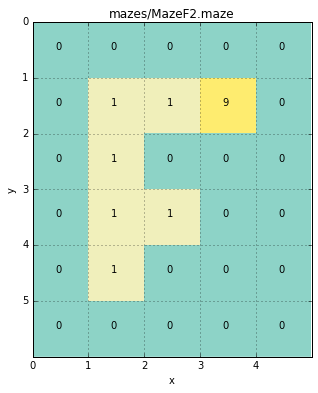

In [5]:
env = Maze(MAZE_LOCATION)

fig = plt.figure(figsize=(env.max_x, env.max_y))
ax = fig.add_subplot(111, aspect='equal')

# Render maze as image
plt.imshow(env.matrix, interpolation='none', cmap='Set3', aspect='auto',
           extent=[0, env.max_x, env.max_y, 0])

# Add labels to each cell
for x in range(0, env.max_x):
    for y in range(0, env.max_y):
        plt.text(x+0.4, y+0.5, env.matrix[y][x])

ax.set_title(MAZE_LOCATION)
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.xlim(0, env.max_x)
plt.ylim(env.max_y, 0)

plt.xticks(range(0, env.max_x))
plt.yticks(range(0, env.max_y))

plt.grid(True)
plt.show()

**Legend / reward map**:
- `0` is a $wall$ (cannot cross),
- `1` is a $path$ (reward $\rho = 0$),
- `9` is a $price$ (reward $\rho = 1000$)

### Agent
Agent interacts autonomously with the environment.

In this notebook it moves in maze for the certain number of steps.

> **Trial** is a successful run of agent when he manages to find the reward.

> After learning it should take him less and less steps to reach the goal.

At the beginning of each trial an agent is randomly placed inside the maze. He can perceive 4 values (neighbourhood cells - N, E, S, W) and move in 4 directions (N, E, S, W).

### Run the simulation
The whole simulation will run a certain number of times for certain number of steps.

In [ ]:
# Number of experiments
EXPERIMENTS = 20

# Number of agent steps for each experiment
STEPS = 3000 # 10 000

# Maximum number of steps in single trial (before resetting an animat)
# Set to None for no limits
MAX_STEPS_IN_TRIAL = 50

# Amount of processes pool
PROCESSES = 2

Let's declare a function performing a single experiment.

We are:
1. initializing an agent,
2. instructing him to collect specified measurements,
3. initializing the environment,
4. running the simulation,
5. returning obtained classifiers and metrics


In [ ]:
def perform_experiment(experiment):
    # Initialize the agent
    agent = ACS2()
    agent.add_metrics_handlers([
        ActualStep('time'),
        SuccessfulTrial('found_reward'),
        ClassifierPopulationSize('total_classifiers'),
        AveragedFitnessScore('average_fitness'),
        AveragedConditionSpecificity('average_specificity'),
        AchievedKnowledge('achieved_knowledge')
    ])

    # Initialize the environment
    env = Maze(MAZE_LOCATION)

    # Evaluate algorithm
    classifiers, metrics = agent.evaluate(env, STEPS, MAX_STEPS_IN_TRIAL)

    # Add information about the experiment into metrics
    metrics['experiment_id'] = [experiment] * len(metrics['time'])

    return classifiers, metrics

Then firing many jobs in parallel.

In [ ]:
all_classifiers = []
all_metrics = pd.DataFrame()

with ProcessPoolExecutor(PROCESSES) as executor:
    futures = []

    for i in range(EXPERIMENTS):
        future = executor.submit(perform_experiment, i)
        futures.append(future)

    for idx, el in enumerate(as_completed(futures)):
        classifiers, metrics = el.result()

        all_classifiers.append(classifiers)
        all_metrics = all_metrics.append(pd.DataFrame(metrics))

We can also inspect how the classifier population looks. Internal model of the environment is specified only by reliable classifiers.

In [ ]:
# take classifiers from the first experiment
classifiers = all_classifiers[0]

# Select only 'reliable' ones
reliable = [c for c in classifiers if c.q > 0.9]

print("Population classifiers: {}".format(len(classifiers)))
print("Reliable classifiers: {}\n".format(len(reliable)))

for cls in reliable:
    print(cls)

<p style="color:red">**TODO**: There are duplicate classifiers!!!! Maybe subsumption does not works. Why low quality classifiers are not removed?</p>

## Performance metrics
Let's have a look how the performance metrics look like by taking 5 random samples:

In [ ]:
all_metrics.sample(5)

### Number of steps to food
Measures if the classifier actually *learns* something along the time.

> **Number of steps to food** - How many steps were needed in **each trial** to found the reward.

We need to have a little helper function for operating on obtained measurements.

In [ ]:
def get_avg_number_of_steps_to_food(performance):
    trials_by_experiment = pd.DataFrame(performance
                                        .groupby('experiment_id')
                                        .apply(lambda x: x['found_reward'].cumsum())
                                        .stack())
    trials_by_experiment.reset_index(inplace=True)
    trials_by_experiment.rename(columns = {'found_reward': 'time', 0: 'trial'},
                                inplace=True)

    # Experiment_id, trial, steps
    steps_per_trial_in_experiment = pd.DataFrame(trials_by_experiment
                                                 .groupby(['experiment_id', 'trial'])
                                                 .size())
    steps_per_trial_in_experiment.reset_index(inplace=True)
    steps_per_trial_in_experiment.rename(columns = {0: 'steps'}, inplace=True)

    # Trial, averaged steps
    averaged_steps_per_trial = pd.DataFrame(steps_per_trial_in_experiment.groupby('trial')['steps'].mean())
    averaged_steps_per_trial.rename(columns = {'steps': 'averaged_steps'}, inplace=True)
    averaged_steps_per_trial.reset_index(inplace=True)
    
    return averaged_steps_per_trial

Now we can visualize the results

In [ ]:
steps_to_food = get_avg_number_of_steps_to_food(all_metrics)

fig = plt.figure(figsize=(15, 8), dpi=100)

plt.bar(steps_to_food['trial'], steps_to_food['averaged_steps'])
plt.title('Averaged number of steps to food')
plt.xlabel('Trial')
plt.ylabel('Steps')

# plt.yscale('log')
plt.grid(True)

plt.show()

### Achieved knowledge
Measures if an agent is *learning* the environment.

> **Achieved knowledge** - test whether or not there is a **reliable classifier** for each transition $(\sigma_{1}, \alpha, \sigma_{2})$ with $\sigma_{1} \neq \sigma_{2}$ that can be applied in $\sigma_{1}$ and anticipates $\sigma_{2}$ correctly.

This metric is calculated after each time-step done by the agent.

In [ ]:
def get_avg_achieved_knowledge_per_step(performance):
    knowledge_per_step = pd.DataFrame(performance.groupby('time')['achieved_knowledge'].mean())
    knowledge_per_step.reset_index(inplace=True)
    return knowledge_per_step

Plot the results

In [ ]:
knowledge_per_step = get_avg_achieved_knowledge_per_step(all_metrics)

fig = plt.figure(figsize=(15, 8), dpi=100)

plt.plot(knowledge_per_step['time'], knowledge_per_step['achieved_knowledge'], 'r')
plt.title('Averaged achieved knowledge')
plt.xlabel('Step')
plt.ylabel('Achieved knowledge')

plt.grid(True)

plt.show()

### Specificity measure
Measure the *generalization* in classifier population.

> **Specificity measure** - Equal to the **sum** of all specialized attributed in condition part of all classifiers in population **divided** by the number of classifiers **times** the length of  the perception $\sigma$.

You can read more about this metric in "*Introducing a Genetic Generalization Pressure to the
Anticipatory Classfierier System - Part2: Performance Analysis*" by Martin V. Butz.

Plot should change after modifing the agent's *mutation* and *cross over* values. The author claims that the best generalization was reached for mutation rate $\mu = 0.4$.

In [ ]:
def get_avg_specificity_per_step(performance):
    spec_per_step = pd.DataFrame(performance.groupby('time')['average_specificity'].mean())
    spec_per_step.reset_index(inplace=True)
    return spec_per_step

Plot the results

In [ ]:
spec_per_step = get_avg_specificity_per_step(all_metrics)

fig = plt.figure(figsize=(15, 8), dpi=100)

plt.plot(spec_per_step['time'], spec_per_step['average_specificity'], 'r', linewidth=2)
plt.title('Averaged specificity of condition parts for classifiers')
plt.xlabel('Step')
plt.ylabel('Specificity')

plt.grid(True)

plt.show()

We can observe that the value stabilizes near 0.45 which means most elements of condition part is wildcards.

We can execute another experiment, but this time also the mutation ratio will change.

The following image presents how the alternative plot can look like:
![title](temp/generalization.png)

Prepare variables for the simulation

In [ ]:
# Create an array containing possible values of mutation rate
mutation_rates = np.arange(0, 1, 0.2)

# Number of experiments
EXPERIMENTS = 10

# Number of steps in each experiment
STEPS = 1000

Run the simulation

In [ ]:
performance = pd.DataFrame()

for experiment in range(EXPERIMENTS):
    print("Experiment: [{}]".format(experiment))
    
    for mutation_rate in mutation_rates:
        print("\tMutation rate: {}".format(mutation_rate))
        
        # Re-initialize the environment
        env = Maze(MAZE_LOCATION)

        # Initialize the agent with metric handler
        agent = ACS2(mu=mutation_rate)
        agent.add_metrics_handlers([
            ActualStep('time'),
            AveragedConditionSpecificity('average_specificity'),
        ])
        
        # Evaluate algorithm
        #classifiers, metrics = agent.evaluate(env, STEPS)

        # Add information about the experiment into metrics
        metrics['experiment_id'] = [experiment] * len(metrics['time'])
        metrics['mutation_rate'] = [mutation_rate] * len(metrics['time'])

        # Append performance metrics
        performance = performance.append(pd.DataFrame(metrics))

To calculate the condition specificity we will take it's value obtained after last step in each experiment and average it.

In [ ]:
def get_avg_specificity_by_mutation_rate(performance):
    last_as_by_experiment = pd.DataFrame(performance
                                         .groupby(['experiment_id','mutation_rate'])['average_specificity']
                                         .last())
    last_as_by_experiment.reset_index(inplace=True)
    
    avg_as_by_mutation_rate = pd.DataFrame(last_as_by_experiment
                                           .groupby(['mutation_rate'])['average_specificity']
                                           .mean())
    avg_as_by_mutation_rate.reset_index(inplace=True)
    
    return avg_as_by_mutation_rate

See how the results look like

In [ ]:
avg_as_by_mutation_rate = get_avg_specificity_by_mutation_rate(performance)
avg_as_by_mutation_rate

In [ ]:
fig = plt.figure(figsize=(15, 8), dpi=100)

plt.plot(avg_as_by_mutation_rate['mutation_rate'],
         avg_as_by_mutation_rate['average_specificity'], 'r', linewidth=2)
plt.title('Averaged specificity ratio')
plt.xlabel('Mutation rate')
plt.ylabel('Specificity')

plt.grid(True)
plt.show()